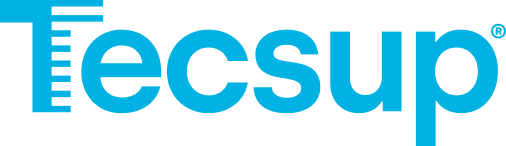

# DEPARTAMENTO DE TECNOLOGÍA DIGITAL Y GESTIÓN
## Carrera de Big Data y Ciencia de Datos
# LABORATORIO 11: ALGORITMOS GENÉTICOS Y EVOLUCIÓN DE LA POBLACIÓN

## Integrantes:
- Joshua Jian Cora Salazar
- Kevin Estiben Olortegui Perez

## 1. VARIABLES GLOBALES:

In [1]:
# URL del dataset CSV (convertido para descarga directa desde Google Drive)
DATA_URL: str = "https://drive.google.com/uc?id=1Gn2_7CGAX0D0M3Ka3JKSjlEdrWbKCxH0"

# Columnas numéricas relevantes para el análisis
NUMERIC_COLS: list[str] = ['TV', 'Radio', 'Newspaper', 'Sales']

# Semilla para reproducibilidad
SEED: int = 42

In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import random
from deap import base, creator, tools, algorithms

In [3]:
# !pip install polars numpy matplotlib scikit-learn deap

## 2. FUNCIONES (utils.py)

In [4]:
%%writefile utils.py
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


def load_data(url: str) -> pl.DataFrame:
    """
    Carga un archivo CSV desde una URL.

    Args:
        url (str): URL del archivo CSV.

    Returns:
        pl.DataFrame: DataFrame con los datos cargados.
    """
    return pl.read_csv(url)


def remove_outliers(df: pl.DataFrame, columns: List[str]) -> pl.DataFrame:
    """
    Elimina outliers univariados usando el rango intercuartílico (IQR).

    Args:
        df (pl.DataFrame): DataFrame original.
        columns (List[str]): Lista de columnas a evaluar.

    Returns:
        pl.DataFrame: DataFrame sin outliers.
    """
    for col in columns:
        if df[col].dtype in [pl.Float64, pl.Int64]:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            df = df.filter((pl.col(col) >= lower) & (pl.col(col) <= upper))
    return df


def scale_columns(df: pl.DataFrame, columns: List[str]) -> pl.DataFrame:
    """
    Aplica escalamiento estándar (Z-score) a las columnas numéricas.

    Args:
        df (pl.DataFrame): DataFrame original.
        columns (List[str]): Columnas a escalar.

    Returns:
        pl.DataFrame: DataFrame con columnas escaladas.
    """
    scaler = StandardScaler()
    scaled = [pl.Series(f"{col}_scaled", scaler.fit_transform(df[col].to_numpy().reshape(-1, 1)).flatten()) for col in columns]
    return df.with_columns(scaled)


def evaluate_model(X: np.ndarray, y: np.ndarray) -> float:
    """
    Evalúa un modelo de regresión lineal con train/test split (80/20).

    Args:
        X (np.ndarray): Matriz de características.
        y (np.ndarray): Vector objetivo.

    Returns:
        float: R² score del modelo.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


def train_final_model(X: np.ndarray, y: np.ndarray) -> Tuple[LinearRegression, float]:
    """
    Entrena y evalúa un modelo final de regresión lineal.

    Args:
        X (np.ndarray): Características seleccionadas.
        y (np.ndarray): Objetivo.

    Returns:
        Tuple[LinearRegression, float]: Modelo entrenado y R² en test.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, r2_score(y_test, y_pred)


def plot_evolution(logbook) -> None:
    """
    Grafica la evolución del coeficiente R² por generación.

    Args:
        logbook: Registro generado por DEAP.
    """
    import matplotlib.pyplot as plt
    gens = logbook.select('gen')
    maxs = logbook.select('max')
    avgs = logbook.select('avg')

    plt.figure(figsize=(10, 6))
    plt.plot(gens, maxs, label="Máximo R²")
    plt.plot(gens, avgs, label="Promedio R²")
    plt.xlabel("Generación")
    plt.ylabel("R²")
    plt.title("Evolución del R²")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Grafica las predicciones frente a los valores reales.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Valores Reales (escalados)')
    plt.ylabel('Predicciones (escalados)')
    plt.title('Predicciones vs Valores Reales')
    plt.grid(True)
    plt.show()

Overwriting utils.py


## 3. IMPLEMENTACIÓN PRINCIPAL

### Parte A: Preprocesamiento de datos

In [5]:
from utils import *
from deap import base, creator, tools, algorithms
import random

In [6]:
random.seed(SEED)
np.random.seed(SEED)

Cargar y limpiar datos

In [7]:
print("Cargando datos...")
df = load_data(DATA_URL)
print("Tratando outliers...")
df_clean = remove_outliers(df, NUMERIC_COLS)
print("Escalando columnas...")
df_scaled = scale_columns(df_clean, NUMERIC_COLS)

Cargando datos...
Tratando outliers...
Escalando columnas...


### Parte B: Configuración y ejecución del algoritmo genético

In [8]:
X = df_scaled.select([f"{col}_scaled" for col in NUMERIC_COLS if col != 'Sales']).to_numpy()
y = df_scaled['Sales_scaled'].to_numpy()
feature_names = [col for col in NUMERIC_COLS if col != 'Sales']

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolbox setup
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(feature_names))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_individual(individual):
    selected = [feature_names[i] for i, bit in enumerate(individual) if bit == 1]
    if not selected:
        return 0.0,
    X_sel = df_scaled.select([f"{col}_scaled" for col in selected]).to_numpy()
    return evaluate_model(X_sel, y),

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

params = {'population_size': 50, 'crossover_prob': 0.7, 'mutation_prob': 0.2, 'generations': 20}
pop = toolbox.population(n=params['population_size'])
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=params['crossover_prob'], mutpb=params['mutation_prob'],
                               ngen=params['generations'], stats=stats, halloffame=hof, verbose=False)

### Parte C: Evaluación y visualización


Variables seleccionadas: ['TV', 'Radio']

R² final en test: 0.9029

Coeficientes del modelo:
TV: 0.7444
Radio: 0.5294
Intercepto: 0.0007


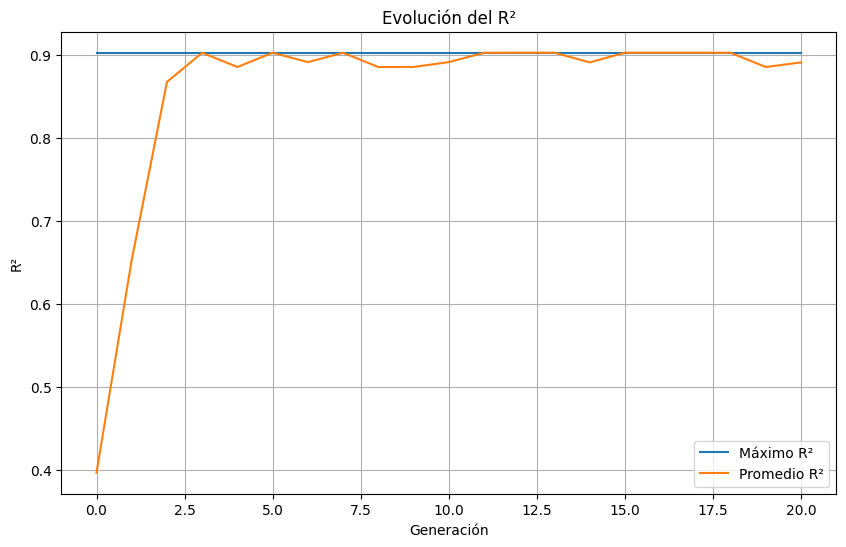

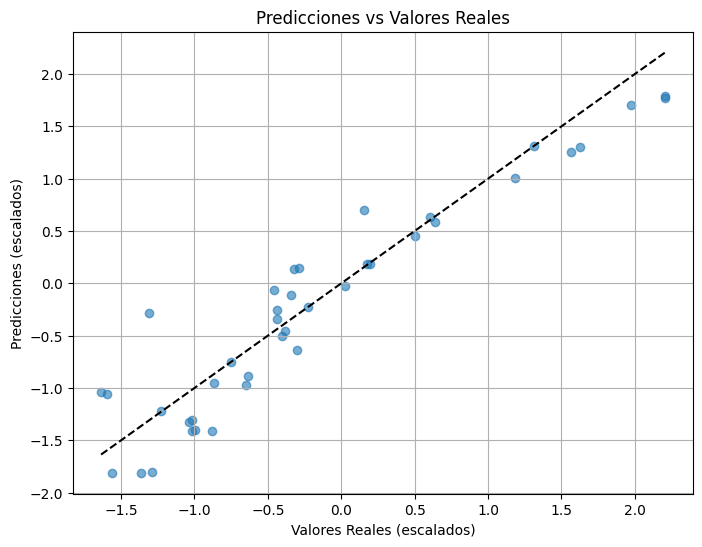

In [9]:
best_ind = hof[0]
selected_features = [feature_names[i] for i, bit in enumerate(best_ind) if bit == 1]
print("\nVariables seleccionadas:", selected_features)

X_final = df_scaled.select([f"{col}_scaled" for col in selected_features]).to_numpy()
final_model, final_r2 = train_final_model(X_final, y)

print("\nR² final en test:", round(final_r2, 4))
print("\nCoeficientes del modelo:")
for feat, coef in zip(selected_features, final_model.coef_):
    print(f"{feat}: {coef:.4f}")
print(f"Intercepto: {final_model.intercept_:.4f}")

plot_evolution(log)
plot_predictions(y_true=y[::5], y_pred=final_model.predict(X_final[::5]))

## 4. TESTING (test_utils.py)

In [10]:
%%writefile test_utils.py
import pytest
import numpy as np
import polars as pl
from sklearn.linear_model import LinearRegression
from utils import (
    remove_outliers,
    scale_columns,
    evaluate_model,
    train_final_model
)


@pytest.fixture
def sample_data():
    data = {
        "TV": [100, 150, 200, 300, 1000],  # 1000 es un outlier
        "Radio": [20, 25, 30, 35, 40],
        "Newspaper": [10, 15, 10, 15, 500],  # 500 es un outlier
        "Sales": [10, 15, 20, 25, 30]
    }
    return pl.DataFrame(data)


def test_remove_outliers(sample_data):
    df_filtered = remove_outliers(sample_data, ["TV", "Newspaper"])
    
    # Verifica que los outliers han sido eliminados
    assert df_filtered.shape[0] < sample_data.shape[0]
    assert df_filtered["TV"].max() < 1000
    assert df_filtered["Newspaper"].max() < 500


def test_scale_columns(sample_data):
    df_scaled = scale_columns(sample_data, ["TV", "Radio"])
    
    # Verifica que se han añadido las columnas escaladas
    assert "TV_scaled" in df_scaled.columns
    assert "Radio_scaled" in df_scaled.columns
    
    # Verifica media ~0 y std ~1
    tv_scaled = df_scaled["TV_scaled"].to_numpy()
    assert np.isclose(tv_scaled.mean(), 0, atol=1e-7)
    assert np.isclose(tv_scaled.std(ddof=0), 1, atol=1e-7)


def test_evaluate_model_normal_case():
    X = np.array([[i] for i in range(10)])
    y = np.array([2 * i for i in range(10)])

    score = evaluate_model(X, y)

    assert isinstance(score, float)
    assert 0.9 <= score <= 1.0



def test_evaluate_model_empty():
    # Edge case: vacío
    X = np.array([]).reshape(0, 1)
    y = np.array([])
    
    with pytest.raises(ValueError):
        evaluate_model(X, y)


def test_train_final_model_output():
    X = np.array([[i] for i in range(10)])
    y = np.array([2 * i for i in range(10)])

    model, score = train_final_model(X, y)

    assert isinstance(score, float)
    assert isinstance(model, LinearRegression)
    assert 0.9 <= score <= 1.0


def test_train_final_model_mismatch_shape():
    X = np.array([[1], [2], [3]])
    y = np.array([1, 2])  # Mal dimensionado
    
    with pytest.raises(ValueError):
        train_final_model(X, y)


Overwriting test_utils.py


## 5. EJECUCIÓN

In [11]:
# !pip install pytest

In [12]:
# Ejecutar los tests
!pytest test_utils.py -v

============================= test session starts =============================
platform win32 -- Python 3.13.3, pytest-8.3.5, pluggy-1.6.0 -- c:\Users\kevin\Desktop\MD\lab11\olortegui_lab11\.venv\Scripts\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\kevin\Desktop\MD\lab11\olortegui_lab11
collecting ... collected 6 items

test_utils.py::test_remove_outliers PASSED                               [ 16%]
test_utils.py::test_scale_columns PASSED                                 [ 33%]
test_utils.py::test_evaluate_model_normal_case PASSED                    [ 50%]
test_utils.py::test_evaluate_model_empty PASSED                          [ 66%]
test_utils.py::test_train_final_model_output PASSED                      [ 83%]
test_utils.py::test_train_final_model_mismatch_shape PASSED              [100%]

============================== 6 passed in 2.47s ==============================
